In [1]:
from deepdow.benchmarks import Benchmark, OneOverN, Random
from deepdow.callbacks import EarlyStoppingCallback, ModelCheckpointCallback
from deepdow.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from deepdow.data.synthetic import sin_single
from deepdow.experiments import Run
from deepdow.layers import SoftmaxAllocator
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from deepdow.layers import NumericalMarkowitz
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from os import path
from typing import Optional, Tuple

import numpy as np
import pandas as pd
import torch
import torch.multiprocessing as mp
import yfinance as yf
from finetuning.finetuning_torch import FinetuningConfig, TimesFMFinetuner
from huggingface_hub import snapshot_download
from torch.utils.data import Dataset

from timesfm import TimesFm, TimesFmCheckpoint, TimesFmHparams
from timesfm.pytorch_patched_decoder import PatchedTimeSeriesDecoder
import os
from deepdow.layers import Conv
from deepdow.layers.collapse import AttentionCollapse, AverageCollapse
from deepdow.layers.misc import CovarianceMatrix

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.11 | packaged by conda-forge | (main, Mar  3 2025, 20:43:55) [GCC 13.3.0].


In [ ]:
import pandas as pd
df = pd.read_parquet('df.parquet')[-2000:]

: 

In [ ]:
#df = raw_df[-300:]
df


Ticker            AAPL                                                \
Price            Close        High         Low        Open    Volume   
Date                                                                   
2017-04-12   32.936779   33.018074   32.753279   32.890324  81400000   
2017-04-13   32.762577   33.071505   32.762577   32.962335  71291600   
2017-04-17   32.943745   32.955359   32.720758   32.862447  66328400   
2017-04-18   32.797409   32.992520   32.776505   32.846189  58790000   
2017-04-19   32.676628   32.983235   32.623206   32.955363  69313600   
...                ...         ...         ...         ...       ...   
2025-03-20  214.100006  217.490005  212.220001  213.990005  48862900   
2025-03-21  218.270004  218.839996  211.279999  211.559998  94127800   
2025-03-24  220.729996  221.479996  218.580002  221.000000  44299500   
2025-03-25  223.750000  224.100006  220.080002  220.770004  34493600   
2025-03-26  221.529999  225.020004  220.470001  223.509995  34466100   

Ticker            AMGN                                               ...  \
Price            Close        High         Low        Open   Volume  ...   
Date                                                                 ...   
2017-04-12  128.211761  129.037415  127.511925  129.021685  2248600  ...   
2017-04-13  127.079445  128.667843  126.859272  128.392621  2568800  ...   
2017-04-17  127.472588  127.794987  126.804199  126.867107  2364900  ...   
2017-04-18  126.796326  127.331027  126.033581  127.331027  2532100  ...   
2017-04-19  126.804222  127.889367  126.702007  127.464752  2344100  ...   
...                ...         ...         ...         ...      ...  ...   
2025-03-20  315.040009  315.989990  312.239990  314.179993  2049700  ...   
2025-03-21  316.040009  316.489990  311.160004  311.820007  9995000  ...   
2025-03-24  314.380005  317.579987  313.429993  315.000000  2439400  ...   
2025-03-25  306.859985  314.220001  303.510010  313.980011  2565300  ...   
2025-03-26  305.709991  309.089996  304.350006  306.440002  2375200  ...   

Ticker            WBA                                                   WMT  \
Price           Close       High        Low       Open    Volume      Close   
Date                                                                          
2017-04-12  58.541965  58.726306  58.357624  58.449798   2984300  21.294033   
2017-04-13  58.478146  58.974442  58.385972  58.719202   2780800  21.209949   
2017-04-17  58.939011  58.960285  58.506521  58.584512   1931600  21.308529   
2017-04-18  58.719227  58.882299  58.506525  58.563246   2894300  21.424511   
2017-04-19  59.208435  59.555843  58.818484  58.995733   5163500  21.476704   
...               ...        ...        ...        ...       ...        ...   
2025-03-20  11.120000  11.200000  11.120000  11.160000  12048300  85.574997   
2025-03-21  11.100000  11.190000  11.080000  11.110000  37249800  85.980003   
2025-03-24  11.150000  11.150000  11.090000  11.120000  12137700  87.489998   
2025-03-25  11.120000  11.170000  11.120000  11.150000   7945800  84.760002   
2025-03-26  11.100000  11.150000  11.100000  11.120000   9880500  85.209999   

Ticker                                                 
Price            High        Low       Open    Volume  
Date                                                   
2017-04-12  21.407115  21.238944  21.325928  19881900  
2017-04-13  21.357825  21.209949  21.273739  16009200  
2017-04-17  21.334623  21.209944  21.212844  16396200  
2017-04-18  21.485402  21.305632  21.323028  19883700  
2017-04-19  21.566588  21.415814  21.485402  17821800  
...               ...        ...        ...       ...  
2025-03-20  86.841523  85.285790  85.574997  18185500  
2025-03-21  86.230003  84.779999  85.279999  26797200  
2025-03-24  87.650002  86.349998  86.470001  17900700  
2025-03-25  87.309998  84.620003  86.760002  27908600  
2025-03-26  85.559998  84.570000  85.190002  27228800  

[2000 rows x 150 columns]

: 

In [ ]:
horizon_len = 30
patch_len = 32
patch_num = 2
batch_size = 96
hidden_size = 128
channels = ['Close', 'High','Low',	'Open',	'Volume']

: 

In [ ]:
def get_model(load_weights: bool = False, horizon_len: int = 7):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  repo_id = "google/timesfm-2.0-500m-pytorch"
  hparams = TimesFmHparams(
      backend=device,
      per_core_batch_size=32,
      horizon_len=horizon_len,
      num_layers=50,
      use_positional_embedding=False,
      context_len=2048,  # Context length can be anything up to 2048 in multiples of 32
      input_patch_len=patch_len
  )
  tfm = TimesFm(hparams=hparams,
                checkpoint=TimesFmCheckpoint(huggingface_repo_id=repo_id))

  model = PatchedTimeSeriesDecoder(tfm._model_config)
  if load_weights:
    checkpoint_path = path.join(snapshot_download(repo_id), "torch_model.ckpt")
    loaded_checkpoint = torch.load(checkpoint_path, weights_only=True)
    model.load_state_dict(loaded_checkpoint)
  return model, hparams, tfm._model_config

: 

In [ ]:
sfm_model, a, b = get_model(load_weights=True)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

: 

In [ ]:
sfm_model.to('cuda')

PatchedTimeSeriesDecoder(
  (input_ff_layer): ResidualBlock(
    (hidden_layer): Sequential(
      (0): Linear(in_features=64, out_features=1280, bias=True)
      (1): SiLU()
    )
    (output_layer): Linear(in_features=1280, out_features=1280, bias=True)
    (residual_layer): Linear(in_features=64, out_features=1280, bias=True)
  )
  (freq_emb): Embedding(3, 1280)
  (horizon_ff_layer): ResidualBlock(
    (hidden_layer): Sequential(
      (0): Linear(in_features=1280, out_features=1280, bias=True)
      (1): SiLU()
    )
    (output_layer): Linear(in_features=1280, out_features=1280, bias=True)
    (residual_layer): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (stacked_transformer): StackedDecoder(
    (layers): ModuleList(
      (0-49): 50 x TimesFMDecoderLayer(
        (self_attn): TimesFMAttention(
          (qkv_proj): Linear(in_features=1280, out_features=3840, bias=True)
          (o_proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (

: 

In [ ]:
from deepdow.utils import raw_to_Xy


n_timesteps = len(df)  # 20
n_channels = len(channels)  # 2
n_assets = len(df.columns.levels[0])  # 2

lookback, gap, horizon = patch_len*patch_num, 2, horizon_len

X, timestamps, y, asset_names, indicators = raw_to_Xy(df,
                                                      lookback=lookback,
                                                      gap=gap,
                                                      freq="B",
                                                      horizon=horizon,
                                                      included_indicators=channels)

n_samples =  n_timesteps - lookback - horizon - gap + 1  # 10

# assert X.shape == (n_samples, n_channels, lookback, n_assets)
# assert timestamps[0] == raw_df.index[lookback]
# assert asset_names == tickers
# assert indicators == ['Close', 'High', 'Low', 'Open', 'Volume']

: 

In [ ]:
print('X: {}, y: {}'.format(X.shape, y.shape))

X: (1980, 5, 64, 30), y: (1980, 5, 30, 30)


: 

In [ ]:
n_samples

1905

: 

In [ ]:
split_ix = int(n_samples * 0.9)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
                                                     indices_test[0], indices_test[-1]))

Train range: 0:1713
Test range: 1808:1904


: 

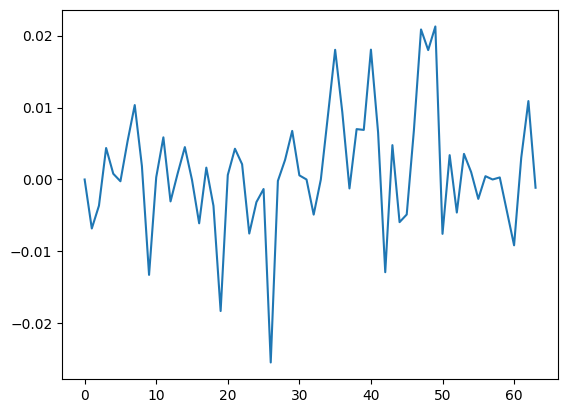

: 

In [ ]:
plt.plot(X[1, 1, :, 1])

In [ ]:
means, stds = prepare_standard_scaler(X, indices=indices_train)
print('mean: {}, std: {}'.format(means, stds))

mean: [0.00039184 0.00039121 0.00038837 0.00038901 0.00021096], std: [0.01793062 0.01557954 0.01650678 0.01744592 0.34394059]


: 

In [ ]:
dataset = InRAMDataset(X, y, transform=Scale(means, stds))

: 

In [ ]:
dataloader_train = RigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=batch_size)

dataloader_test = RigidDataLoader(dataset,
                                  indices=indices_test,
                                  batch_size=batch_size)

: 

In [ ]:
device = 'cuda'

: 

In [ ]:
class GreatNet(torch.nn.Module, Benchmark):
    def __init__(self, n_assets, lookback, channels, hidden_size = 128, p=0.1, max_weight=1., n_output_channels = 4):
        super().__init__()

        super().__init__()

        n_features =  patch_num * 128 # 输入特征数
        
     
        self.CollapseChannel = Conv(n_input_channels=channels,
             n_output_channels=1,
             kernel_size=3,
             method='2D')
        layers = []

        layers.append(nn.Linear(channels, 1))
        layers.append(nn.ReLU())
        self.CollapseChannel = nn.Sequential(*layers)
        
        # self.CollapseSFM = Conv(n_input_channels=n_features,
        #      n_output_channels=hidden_size,
        #      kernel_size=3,
        #      method='1D')
        
        # self.CollapseSFM_2 = Conv(n_input_channels=hidden_size,
        #      n_output_channels=1,
        #      kernel_size=3,
        #      method='1D')
        # 参数
        d_model = 128  # 隐藏维度
        nhead = 8      # 注意力头数
        num_encoder_layers = 6  # 编码器层数
        num_decoder_layers = 6  # 解码器层数
        dim_feedforward = 2048  # 前馈层中间维度
        self.decode_layer = nn.TransformerDecoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=p,
                batch_first=True
            )
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)
        layers = []

        layers.append(nn.Linear(n_features, 1))
        layers.append(nn.ReLU())
        self.CollapseSFM = nn.Sequential(*layers)
        
        self.layer_L3 = AverageCollapse()
        self.layer_L4 = CovarianceMatrix(sqrt=False)
        self.layer_L5 = NumericalMarkowitz(n_assets)
        # Dropout 层
        self.dropout_layer = nn.Dropout(p=p)
        
        # 10 层网络
        layers = []
        # 第 1 层：输入层
        layers.append(nn.Linear(patch_num*1280, hidden_size))
        layers.append(nn.ReLU())
        
        
        # 将所有层组合成 Sequential
        self.network = nn.Sequential(*layers)
        self.dense_layer = torch.nn.Linear(n_features, n_assets, bias=True)
        # Softmax 分配层和温度参数
        self.allocate_layer = SoftmaxAllocator(temperature=None, n_assets= n_assets, formulation='variational', max_weight=0.5)
        self.temperature = nn.Parameter(torch.ones(1), requires_grad=True)
        

    def forward(self, x):
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        n_samples, channels, lookback, n_assets = x.shape
        # x = x.permute(0, 3, 1, 2)
        # x = x.reshape(n_samples, n_assets*channels, -1) 
        with torch.no_grad():
            xx_list = []
            for i in range(channels):
                xx = x[:,i,:,:].squeeze(1)
                xx = xx.permute(0, 2, 1)
                xx = xx.contiguous()
                input_padding = torch.zeros_like(xx).to(device)
                freq = torch.tensor([0], dtype=torch.long).to(device)
                xx = sfm_model(xx, input_padding, freq)
                xx = xx[:,:,:,5]
                #xx = xx.squeeze(2)
                #xx = xx.unsqueeze(1) # B, 1, n_assets*patch_num, 128
                
                xx_list.append(xx)
        x = self.decode_layer(xx)
        x = torch.cat(xx_list, dim=1) # B, channels, n_assets*patch_num, 128
        x = x.view(n_samples, channels, n_assets, patch_num*128)  # 
        x = x.permute(0,2,3,1) # B, n_assets, patch_num*128, channels,   ## B, channels, patch_num*128, n_assets
        #x = x.reshape(n_samples, n_assets, channels*patch_num*128) # B, n_assets, channels*patch_num*128
        x = self.CollapseChannel(x) # B,  n_assets,  patch_num*128, 1
        x = self.dropout_layer(x)
        x = x.squeeze(-1)
        

        x = self.CollapseSFM(x) # B,  n_assets,   1
        x = self.dropout_layer(x)
        
        # x = self.CollapseSFM_2(x)
        # x = self.dropout_layer(x)
        
        x = x.squeeze(-1)
        
        #x = self.dense_layer(x)
        # 计算权重
        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

: 

In [ ]:
class DeepNet(torch.nn.Module, Benchmark):
    def __init__(self, n_assets, lookback, channels, hidden_size = 128, p=0.1, max_weight=1., n_output_channels = 4):
        super().__init__()

        super().__init__()

        n_features =  patch_num * 128 # 输入特征数
        
     
        self.CollapseChannel = Conv(n_input_channels=channels,
             n_output_channels=1,
             kernel_size=3,
             method='2D')
        

        # 参数
        d_model = 128  # 隐藏维度
        nhead = 8      # 注意力头数
        num_encoder_layers = 6  # 编码器层数
        num_decoder_layers = 6  # 解码器层数
        dim_feedforward = 2048  # 前馈层中间维度
        self.decode_layer = nn.TransformerDecoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=p,
                batch_first=True
            )
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)
        layers = []

        layers.append(nn.Linear(n_features, 1))
        layers.append(nn.ReLU())
        self.CollapseSFM = nn.Sequential(*layers)
        
        self.layer_L3 = AverageCollapse()
        self.layer_L4 = CovarianceMatrix(sqrt=False)
        self.layer_L5 = NumericalMarkowitz(n_assets)
        # Dropout 层
        self.dropout_layer = nn.Dropout(p=p)
        
        # 10 层网络
        layers = []
        # 第 1 层：输入层
        layers.append(nn.Linear(patch_num*1280, hidden_size))
        layers.append(nn.ReLU())
        
        
        # 将所有层组合成 Sequential
        self.network = nn.Sequential(*layers)
        self.dense_layer = torch.nn.Linear(n_features, n_assets, bias=True)
        # Softmax 分配层和温度参数
        self.allocate_layer = SoftmaxAllocator(temperature=None, n_assets= n_assets, formulation='variational', max_weight=0.5)
        self.temperature = nn.Parameter(torch.ones(1), requires_grad=True)
        

    def forward(self, x):
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        n_samples, channels, lookback, n_assets = x.shape
        x = self.CollapseChannel(x) # B, lookback, n_assets
                
        with torch.no_grad():
            
            input_padding = torch.zeros_like(xx).to(device)
            freq = torch.tensor([0], dtype=torch.long).to(device)
            x = sfm_model(x, input_padding, freq) # B, n_assets*patch_num, 128
                
        x = self.decode_layer(x)
        
        x = x.view(n_samples, n_assets, -1)
        
        
        
        x = self.dense_layer(x)
        # 计算权重
        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

: 

In [ ]:
network = DeepNet(n_assets, lookback, channels=n_channels, hidden_size=hidden_size)


: 

In [ ]:
network

GreatNet(
  (CollapseChannel): Sequential(
    (0): Linear(in_features=5, out_features=1, bias=True)
    (1): ReLU()
  )
  (CollapseSFM): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): ReLU()
  )
  (layer_L3): AverageCollapse()
  (layer_L4): CovarianceMatrix()
  (layer_L5): NumericalMarkowitz(
    (cvxpylayer): CvxpyLayer()
  )
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (network): Sequential(
    (0): Linear(in_features=2560, out_features=128, bias=True)
    (1): ReLU()
  )
  (dense_layer): Linear(in_features=256, out_features=30, bias=True)
  (allocate_layer): SoftmaxAllocator(
    (layer): CvxpyLayer()
  )
)

: 

In [ ]:
network_to_train = network.train() 

: 

In [ ]:
#loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio(rf=0.000)
loss = MeanReturns()

: 

In [ ]:
run = Run(network_to_train,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=3),
                     ModelCheckpointCallback(folder_path='./models/',
                                             dataloader_name='test',
                                             metric_name='loss')],
          device=device
          )

#

: 

In [45]:
history = run.launch(30)

Epoch 3: 100%|██████████| 18/18 [00:49<00:00,  2.72s/it, loss=-0.00054, test_loss=-0.00082]


Training interrupted
Training stopped early because there was no improvement in test_loss for 3 epochs


In [46]:
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

print(per_epoch_results.count())  # double check number of samples each epoch
print(per_epoch_results.mean())  # mean loss per epoch

dataloader  metric  model    epoch
test        loss    network  0        97
                             1        97
                             2        97
                             3        97
Name: value, dtype: int64
dataloader  metric  model    epoch
test        loss    network  0       -0.000818
                             1       -0.000818
                             2       -0.000818
                             3       -0.000817
Name: value, dtype: float32


<Axes: xlabel='epoch'>

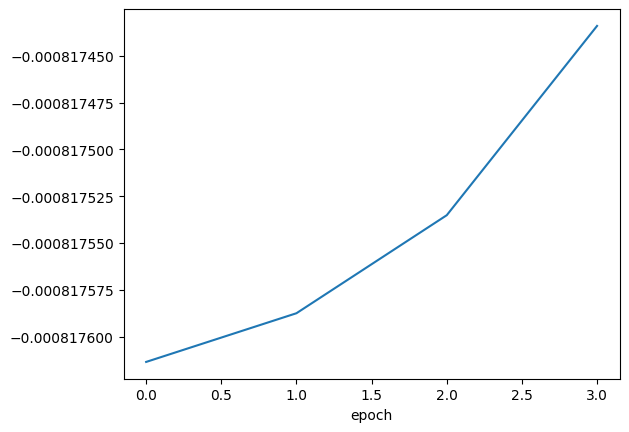

In [47]:
per_epoch_results.mean()['test']['loss']['network'].plot()

In [ ]:
#network = torch.load('models/model_04__-0.0869.pth', weights_only=False)

In [48]:
network = network.eval()

In [49]:
benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    'random': Random(),  # random allocation that is however close 1OverN
    'network': network
}

In [50]:
metrics = {
    'MaxDD': MaximumDrawdown(),
    'Sharpe': SharpeRatio(),
    'MeanReturn': MeanReturns()
}

In [51]:
metrics_table = generate_metrics_table(benchmarks,
                                       dataloader_test,
                                       metrics,
                                       device='cuda')

array([<Axes: title={'center': 'MaxDD'}, xlabel='timestamp'>,
       <Axes: title={'center': 'Sharpe'}, xlabel='timestamp'>,
       <Axes: title={'center': 'MeanReturn'}, xlabel='timestamp'>],
      dtype=object)

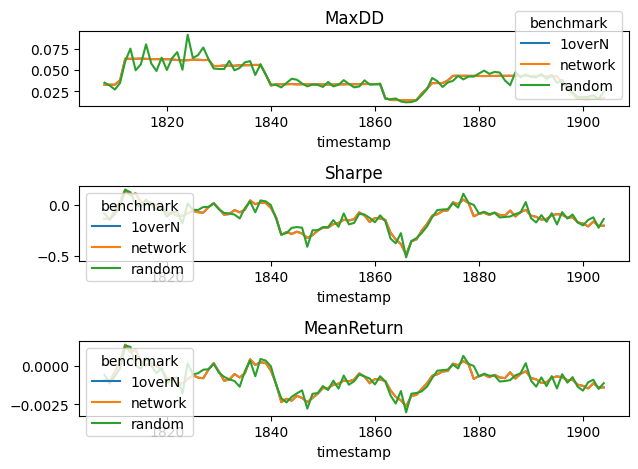

In [52]:
plot_metrics(metrics_table)

In [53]:
weight_table = generate_weights_table(network, dataloader_test,device = device)

<Axes: >

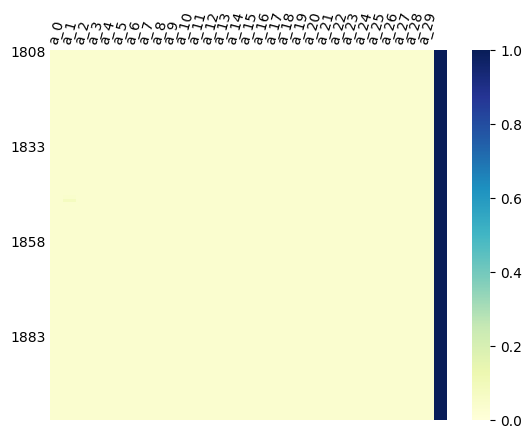

In [54]:
plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)